In [2]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from catboost import CatBoostClassifier

In [3]:
#Data Loading
start_time = time.time()
print("Loading the dataset...")
df = pd.read_csv("C:/Users/harsh/Downloads/phiusiil+phishing+url+dataset/PhiUSIIL_Phishing_URL_Dataset.csv")
print("Dataset loaded successfully.")
print(f"Initial DataFrame shape: {df.shape}\n")

Loading the dataset...
Dataset loaded successfully.
Initial DataFrame shape: (235795, 56)



In [4]:
#Initial Data Inspection  ---
print("Initial 5 rows:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())
print("\nValue counts for 'label' column:")
print(df['label'].value_counts())
print("\nDescriptive statistics for numerical columns:")
print(df.describe())


Initial 5 rows:
     FILENAME                                 URL  URLLength  \
0  521848.txt    https://www.southbankmosaics.com         31   
1   31372.txt            https://www.uni-mainz.de         23   
2  597387.txt      https://www.voicefmradio.co.uk         29   
3  554095.txt         https://www.sfnmjournal.com         26   
4  151578.txt  https://www.rewildingargentina.org         33   

                       Domain  DomainLength  IsDomainIP  TLD  \
0    www.southbankmosaics.com            24           0  com   
1            www.uni-mainz.de            16           0   de   
2      www.voicefmradio.co.uk            22           0   uk   
3         www.sfnmjournal.com            19           0  com   
4  www.rewildingargentina.org            26           0  org   

   URLSimilarityIndex  CharContinuationRate  TLDLegitimateProb  ...  Pay  \
0               100.0              1.000000           0.522907  ...    0   
1               100.0              0.666667           0.032650

In [5]:
#Feature Engineering

# --- Log Transform Skewed Numerical Features ---
print("Applying log transformation to skewed numerical features...")
skewed_columns = [
    'URLLength', 'DomainLength', 'NoOfSubDomain', 'NoOfObfuscatedChar',
    'NoOfLettersInURL', 'NoOfDegitsInURL', 'NoOfEqualsInURL',
    'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL',
    'LineOfCode', 'LargestLineLength', 'NoOfURLRedirect', 'NoOfSelfRedirect',
    'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef',
    'NoOfExternalRef'
]

for col in skewed_columns:
    # Create new columns with '_log' suffix
    df[col + '_log'] = np.log1p(df[col])

# Drop the original skewed columns as we will use their log-transformed versions
df = df.drop(columns=skewed_columns, errors='ignore')
print("Log transformations applied and original skewed columns dropped.")



Applying log transformation to skewed numerical features...
Log transformations applied and original skewed columns dropped.


In [6]:
# --- One-Hot Encoding for TLD ---
print("Handling categorical features (One-Hot Encoding for TLD)...")
print(f"Number of unique TLDs before encoding: {df['TLD'].nunique()}")
print("Top 10 TLDs:")
print(df['TLD'].value_counts().head(10))

# One-hot encode the 'TLD' column
df = pd.get_dummies(df, columns=['TLD'], prefix='TLD')
print("One-hot encoding applied to 'TLD' column.")


#                           4. Missing Values & Irrelevant Column Handling


# --- Handle Missing Values in 'Title' ---
if 'Title' in df.columns and df['Title'].isnull().any():
    df['Title'].fillna('NO_TITLE_FOUND', inplace=True)
    print("Missing values in 'Title' filled.")
else:
    print("No missing values in 'Title' or 'Title' column not present.")



Handling categorical features (One-Hot Encoding for TLD)...
Number of unique TLDs before encoding: 695
Top 10 TLDs:
TLD
com    112554
org     18793
net      7097
app      6508
uk       6395
co       5422
io       4201
de       3996
ru       3875
au       2979
Name: count, dtype: int64
One-hot encoding applied to 'TLD' column.
No missing values in 'Title' or 'Title' column not present.


In [7]:
# --- Drop Irrelevant/Text Columns ---
print("Dropping irrelevant/text columns...")
columns_to_drop = ['URL', 'Domain', 'FILENAME', 'Title']
df = df.drop(columns=columns_to_drop, errors='ignore')
print(f"Columns dropped: {columns_to_drop}")


Dropping irrelevant/text columns...
Columns dropped: ['URL', 'Domain', 'FILENAME', 'Title']


In [8]:
#5. Feature Scaling

print("Applying feature scaling to numerical features...")
# Identify numerical columns for scaling. Exclude one-hot encoded columns and the target 'label'.
all_numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# TLD one-hot encoded columns are typically binary (0 or 1) and don't need scaling.
one_hot_prefix_cols = [col for col in all_numerical_cols if col.startswith('TLD_')]

# List of numerical features to scale (excluding one-hot encoded TLDs and the 'label')
features_to_scale = [col for col in all_numerical_cols if col not in one_hot_prefix_cols and col != 'label']

scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
print("Numerical features scaled using StandardScaler.")

print("\nDataFrame head after all preprocessing (showing some scaled columns):")
# Select a few representative scaled columns and one-hot encoded columns to display
display_cols = [col for col in df.columns if '_log' in col or col.startswith('TLD_') or col in ['IsHTTPS', 'label']]
print(df[display_cols].head())
print(f"Final DataFrame shape after preprocessing: {df.shape}")


Applying feature scaling to numerical features...
Numerical features scaled using StandardScaler.

DataFrame head after all preprocessing (showing some scaled columns):
    IsHTTPS  label  URLLength_log  DomainLength_log  NoOfSubDomain_log  \
0  0.527021      1       0.050626          0.492181          -0.167579   
1  0.527021      1      -0.651174         -0.617054          -0.167579   
2  0.527021      1      -0.106816          0.252360           1.366341   
3  0.527021      1      -0.363843         -0.149620          -0.167579   
4  0.527021      1       0.198519          0.713535          -0.167579   

   NoOfObfuscatedChar_log  NoOfLettersInURL_log  NoOfDegitsInURL_log  \
0                -0.04247              0.261894            -0.465936   
1                -0.04247             -0.831322            -0.465936   
2                -0.04247             -0.030804            -0.465936   
3                -0.04247             -0.258237            -0.465936   
4                -0.04247 

In [9]:
#6. Data Splitting

print("Splitting data into training and testing sets...")
X = df.drop('label', axis=1) # Features
y = df['label']             # Target variable

# Split the data, ensuring stratification for balanced class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

print("\nClass distribution in y_train:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in y_test:")
print(y_test.value_counts(normalize=True))


Splitting data into training and testing sets...
Shape of X_train: (165056, 745)
Shape of X_test: (70739, 745)
Shape of y_train: (165056,)
Shape of y_test: (70739,)

Class distribution in y_train:
label
1    0.571897
0    0.428103
Name: proportion, dtype: float64

Class distribution in y_test:
label
1    0.571891
0    0.428109
Name: proportion, dtype: float64


In [10]:
cat_model = CatBoostClassifier(
    iterations=10,           # Number of boosting iterations (trees)
    learning_rate=0.05,        # Step size shrinkage
    depth=6,                   # Depth of the tree
    loss_function='Logloss',   # For binary classification
    eval_metric='AUC',         # Metric to optimize for evaluation (AUC is good for imbalanced)
    random_seed=42,            # For reproducibility
    verbose=0,                 # Set to 1 or higher for more verbose training logs
    early_stopping_rounds=10,  # Stop if validation metric doesn't improve for  rounds
    auto_class_weights='Balanced', # Automatically sets weights based on class balance
)

print("Training CatBoostClassifier...")
# Using X_test as eval_set to monitor performance and for early stopping.
cat_model.fit(X_train, y_train,
              eval_set=(X_test, y_test), # This is crucial for logging the validation metric
             )
print("CatBoostClassifier training complete.")

Training CatBoostClassifier...
CatBoostClassifier training complete.


In [11]:
# 8. Model Evaluation & Overfitting Check
print("Evaluating model performance...")
y_train_pred_cat = cat_model.predict(X_train)
y_train_proba_cat = cat_model.predict_proba(X_train)[:, 1]
y_test_pred_cat = cat_model.predict(X_test)
y_test_proba_cat = cat_model.predict_proba(X_test)[:, 1]

print(f"\nTraining Accuracy (CatBoost): {accuracy_score(y_train, y_train_pred_cat):.4f}")
print(f"Training ROC-AUC Score (CatBoost): {roc_auc_score(y_train, y_train_proba_cat):.4f}")
print(f"Test Accuracy (CatBoost): {accuracy_score(y_test, y_test_pred_cat):.4f}")
print(f"Test ROC-AUC Score (CatBoost): {roc_auc_score(y_test, y_test_proba_cat):.4f}")

print("\nClassification Report (Test Set - CatBoost):")
print(classification_report(y_test, y_test_pred_cat))
print("\nConfusion Matrix (Test Set - CatBoost):")
print(confusion_matrix(y_test, y_test_pred_cat))

# --- Overfitting Check ---
print("\n--- Overfitting Conclusion from Metrics ---")
train_accuracy = accuracy_score(y_train, y_train_pred_cat)
test_accuracy = accuracy_score(y_test, y_test_pred_cat)
train_roc_auc = roc_auc_score(y_train, y_train_proba_cat)
test_roc_auc = roc_auc_score(y_test, y_test_proba_cat)

if (train_accuracy - test_accuracy > 0.05) or (train_roc_auc - test_roc_auc > 0.05):
    print("Conclusion: There might be some signs of overfitting. The model performs significantly better on the training data than on unseen test data.")
    print("Consider techniques like: increasing regularization, reducing model complexity (e.g., fewer iterations, shallower depth), or more data if available.")
else:
    print("Conclusion: The model does not appear to be significantly overfitting. The performance on training and test sets is comparable.")


Evaluating model performance...

Training Accuracy (CatBoost): 0.9999
Training ROC-AUC Score (CatBoost): 1.0000
Test Accuracy (CatBoost): 0.9998
Test ROC-AUC Score (CatBoost): 1.0000

Classification Report (Test Set - CatBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30284
           1       1.00      1.00      1.00     40455

    accuracy                           1.00     70739
   macro avg       1.00      1.00      1.00     70739
weighted avg       1.00      1.00      1.00     70739


Confusion Matrix (Test Set - CatBoost):
[[30267    17]
 [    0 40455]]

--- Overfitting Conclusion from Metrics ---
Conclusion: The model does not appear to be significantly overfitting. The performance on training and test sets is comparable.


Keys available in evals_result['learn']: dict_keys(['Logloss'])
Keys available in evals_result['validation']: dict_keys(['Logloss', 'AUC'])


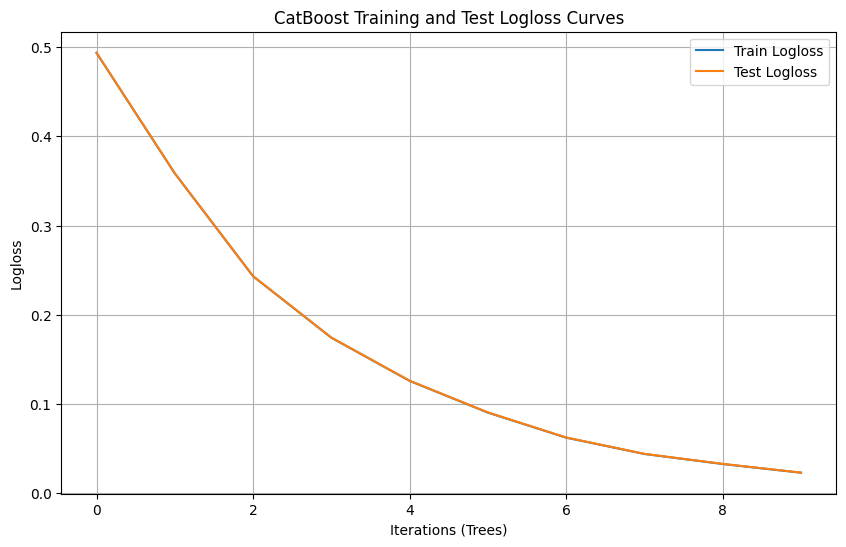

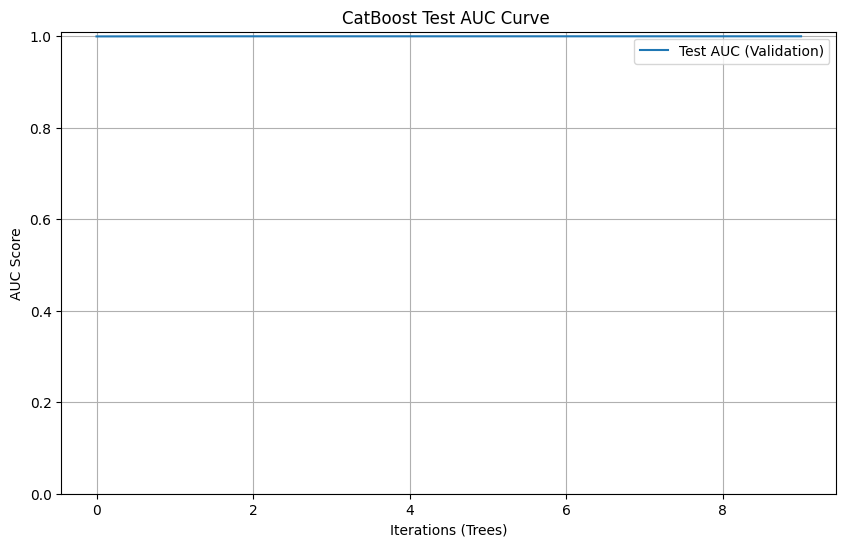

In [12]:
#  9. Plotting Learning Curves
# Retrieve evaluation results
evals_result = cat_model.get_evals_result()

# Debugging: Print keys to see what's available
print("Keys available in evals_result['learn']:", evals_result['learn'].keys())
print("Keys available in evals_result['validation']:", evals_result['validation'].keys())

# Plot Logloss curve (always available for 'learn' and 'validation')
plt.figure(figsize=(10 , 6))
plt.plot(evals_result['learn']['Logloss'], label='Train Logloss')
plt.plot(evals_result['validation']['Logloss'], label='Test Logloss')
plt.xlabel('Iterations (Trees)')
plt.ylabel('Logloss')
plt.title('CatBoost Training and Test Logloss Curves')
plt.legend()
plt.grid(True)
plt.show()

# Plot AUC curve (available only for validation, or need to explicitly log for train)
if 'AUC' in evals_result['validation']:
    plt.figure(figsize=(10, 6))
    # Note: Train AUC is often not logged by default for 'learn' set unless specified.
    # If it becomes available in future versions or with specific params, uncomment:
    # if 'AUC' in evals_result['learn']:
    #     plt.plot(evals_result['learn']['AUC'], label='Train AUC')
    plt.plot(evals_result['validation']['AUC'], label='Test AUC (Validation)')
    plt.xlabel('Iterations (Trees)')
    plt.ylabel('AUC Score')
    plt.title('CatBoost Test AUC Curve ')
    plt.legend()
    plt.grid(True)
    plt.ylim(0,1.01)
    plt.show()


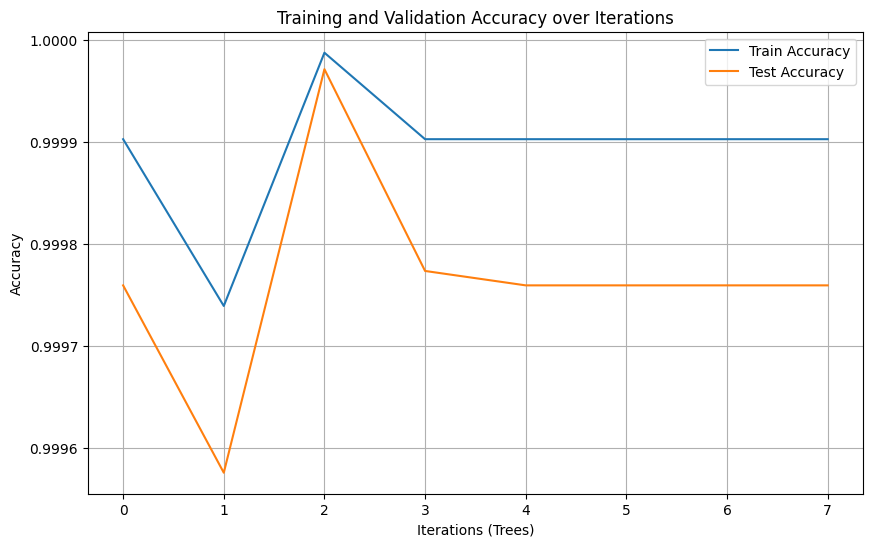

In [13]:
train_accuracy_list = []
test_accuracy_list = []

for i, pred in enumerate(cat_model.staged_predict(X_train)):
    train_accuracy_list.append(accuracy_score(y_train, pred))

for i, pred in enumerate(cat_model.staged_predict(X_test)):
    test_accuracy_list.append(accuracy_score(y_test, pred))

# Now plot it
plt.figure(figsize=(10,6))
plt.plot(train_accuracy_list, label='Train Accuracy')
plt.plot(test_accuracy_list, label='Test Accuracy')
plt.xlabel("Iterations (Trees)")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy over Iterations")
plt.legend()
plt.grid(True)
plt.show()


C:\Users\harsh\AppData\Local\Temp\ipykernel_19744\4210689743.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(normalized_metrics.keys()), y=list(normalized_metrics.values()),


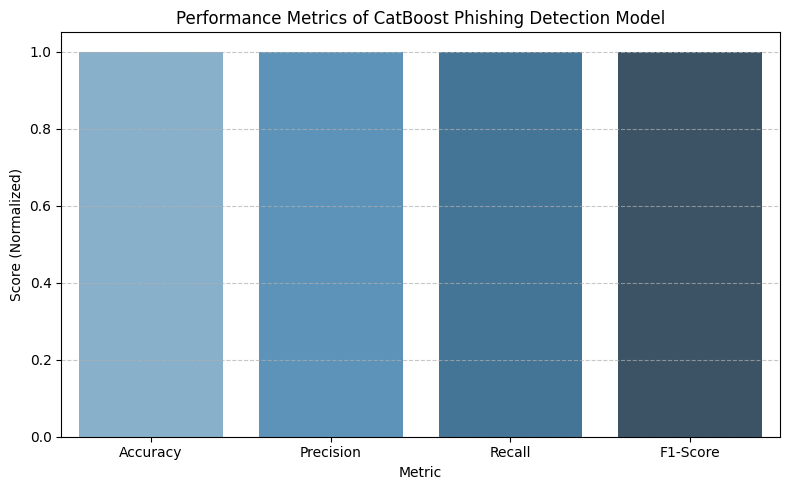

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate the metrics on the test set
accuracy = accuracy_score(y_test, y_test_pred_cat)
precision = precision_score(y_test, y_test_pred_cat)
recall = recall_score(y_test, y_test_pred_cat)
f1 = f1_score(y_test, y_test_pred_cat)

# Create a dictionary of metrics
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

# Normalize the metrics to [0, 1] for plotting
max_score = max(metrics.values())
normalized_metrics = {k: v / max_score for k, v in metrics.items()}

# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=list(normalized_metrics.keys()), y=list(normalized_metrics.values()),
            palette='Blues_d')

plt.title("Performance Metrics of CatBoost Phishing Detection Model")
plt.xlabel("Metric")
plt.ylabel("Score (Normalized)")
plt.ylim(0, 1.05)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



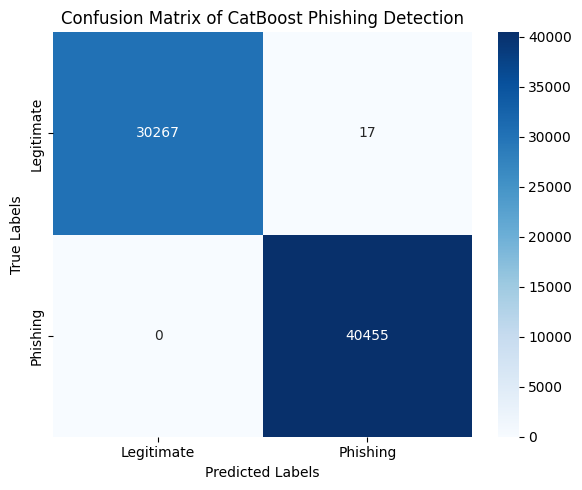

In [17]:
cm = confusion_matrix(y_test, y_test_pred_cat)
labels = ['Legitimate', 'Phishing']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix of CatBoost Phishing Detection")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

In [14]:
end_time = time.time()
print(f"\nTotal execution time: {end_time - start_time:.2f} seconds")



Total execution time: 438.54 seconds


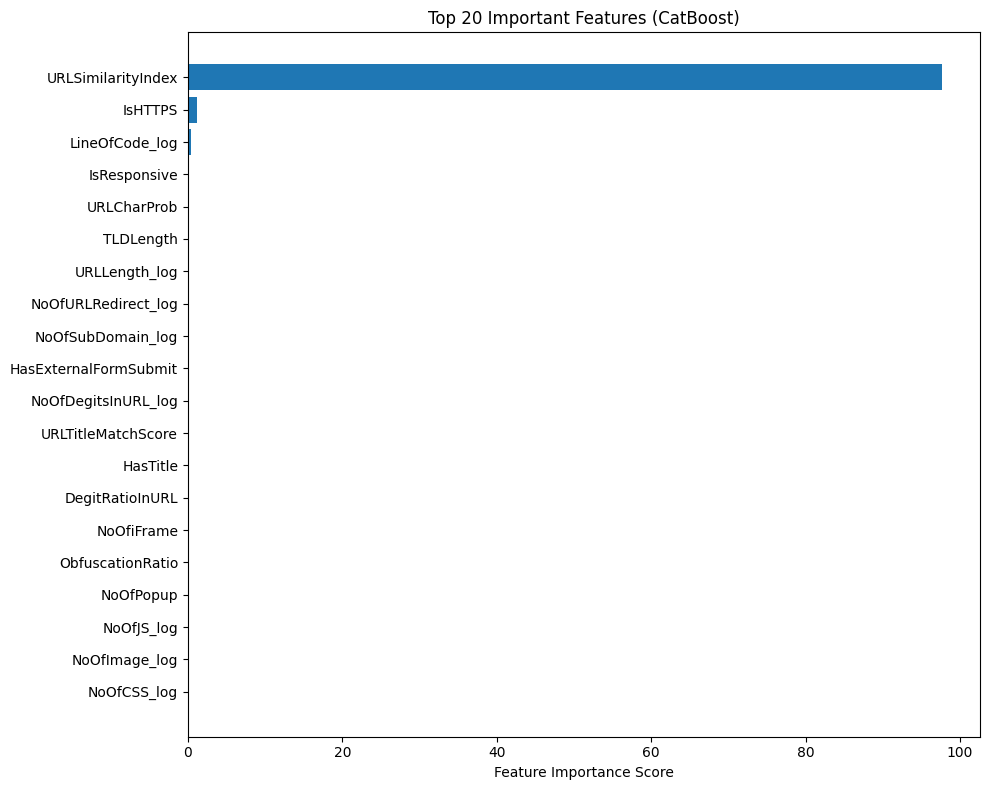

In [15]:
# Get feature importances and names
feature_importance = cat_model.get_feature_importance()
features = X_train.columns

# Sort features by importance
sorted_idx = np.argsort(feature_importance)
sorted_features = features[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

# Plot only top N features (optional, e.g., top 20)
top_n = 20
plt.figure(figsize=(10, 8))
plt.barh(range(top_n), sorted_importance[-top_n:])
plt.yticks(range(top_n), sorted_features[-top_n:])
plt.xlabel("Feature Importance Score")
plt.title("Top 20 Important Features (CatBoost)")
plt.tight_layout()
plt.show()


C:\Users\harsh\AppData\Local\Temp\ipykernel_19744\2484482025.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


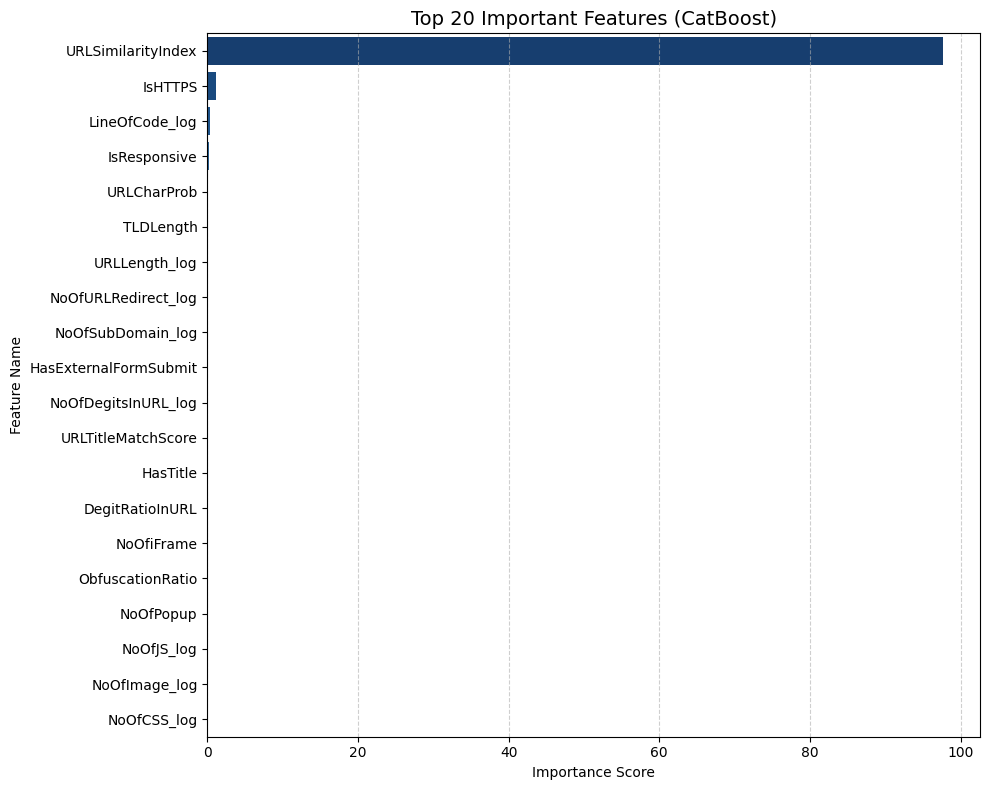

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Get feature importances
feature_importances = cat_model.get_feature_importance()
feature_names = X_train.columns

# Step 2: Create DataFrame and sort
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 3: Plot top N features
top_n = 20
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_df.head(top_n), 
    palette='Blues_r'  # or try "viridis", "mako", etc.
)

# Styling
plt.title('Top 20 Important Features (CatBoost)', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()
